# QML Unified Pipeline — PCA + PQC (Angle vs Amplitude)

In [1]:
# Optional installs (better run in terminal)
# %pip install qiskit scikit-learn matplotlib pandas numpy openpyxl
%matplotlib inline

# Silence noisy logs to avoid collapsed outputs
import warnings, logging, os
warnings.filterwarnings('ignore')
for name in ['qiskit','matplotlib','PIL','urllib3','asyncio','parso','traitlets']:
    logging.getLogger(name).setLevel(logging.ERROR)
os.environ['QISKIT_SUPPRESS_PACKAGING_WARNINGS'] = '1'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from qml_pqc_module import (
    find_default_data_path, load_dataset, dataframe_to_matrix,
    sequential_train_test_split, make_next_step_pairs,
    fit_pca_on_train, transform_with_pca, inverse_pca,
    PQCRegressor, PQCRegressorAmplitude,
    loss_curve, plot_surface_heatmaps, parity_plot,
    rbf_style_rollout_plot, guess_grid_shape, build_angle_circuit
)
from qiskit.visualization import circuit_drawer
from IPython.display import Image

In [3]:
# Configuration
DATA_PATH = 'Dataset_Simulated_Price_swaption.xlsx'  # or None for auto
N_PCA_COMPONENTS = 6
ENTANGLING_DEPTH = 2
TEST_FRACTION = 0.2
GRID_SHAPE = None  # e.g., (10, 10)


In [4]:
# Load dataset
data_path = DATA_PATH or find_default_data_path()
print('Using dataset:', data_path)
df = load_dataset(data_path)
X_raw, timeline = dataframe_to_matrix(df)
n_total, n_features = X_raw.shape
print('Loaded matrix shape:', X_raw.shape)


Using dataset: Dataset_Simulated_Price_swaption.xlsx
Loaded matrix shape: (500, 224)


In [5]:
# Train/test split and next-step pairs
X_train_raw, X_test_raw = sequential_train_test_split(X_raw, TEST_FRACTION)
train_len = X_train_raw.shape[0]
print('Train steps:', train_len, 'Test steps:', X_test_raw.shape[0])

Xtr_pairs_in, Xtr_pairs_out = make_next_step_pairs(X_train_raw)
Xte_pairs_in, Xte_pairs_out = make_next_step_pairs(X_test_raw)


Train steps: 400 Test steps: 100


In [6]:
# PCA on train + transform test
scaler, pca, Xtr_pca = fit_pca_on_train(X_train_raw, N_PCA_COMPONENTS)
Xte_pca = transform_with_pca(scaler, pca, X_test_raw)
print('Explained variance (train PCA):', pca.explained_variance_ratio_.sum())

# Supervised pairs in PCA space
Xtr_in_pca, Xtr_out_pca = make_next_step_pairs(Xtr_pca)
Xte_in_pca, Xte_out_pca = make_next_step_pairs(Xte_pca)
yte_true = Xte_out_pca  # for metrics in PCA or inverse space later


Explained variance (train PCA): 0.9999198361894907


In [13]:
# === Circuit diagnostics for State Preparation ===
from qiskit import transpile
from qiskit.quantum_info import state_fidelity

def describe_circuit(name, qc):
    print(f"\n[{name}]")
    print("qubits:", qc.num_qubits)
    print("depth :", qc.depth())
    print("ops   :", dict(qc.count_ops()))
    # 2Qゲート比率の簡易評価（CX, CZ など）
    twoq = sum(c for g,c in qc.count_ops().items() if g.upper() in ("CX","CZ","ECR","SWAP","CSWAP","CRX","CRY","CRZ"))
    total = sum(qc.count_ops().values())
    ratio = twoq/total if total else 0.0
    print(f"2Q ratio: {ratio:.3f}")

# あなたの2つの回路: qc_state_angle, qc_state_amp
describe_circuit("Angle-encoding state", qc_state_angle)
describe_circuit("Amplitude-encoding state", qc_state_amp)

# （任意）トランスパイルしてハードウェア近傍での深さも見る
backend = None  # Aerシミュレータ想定なら None でOK / 実機なら適切なbackend
tc_angle = transpile(qc_state_angle, backend=backend, optimization_level=3)
tc_amp   = transpile(qc_state_amp,   backend=backend, optimization_level=3)
describe_circuit("Transpiled Angle", tc_angle)
describe_circuit("Transpiled Amp",   tc_amp)


[Angle-encoding state]
qubits: 6
depth : 12
ops   : {'ry': 18, 'rz': 12, 'cx': 10}
2Q ratio: 0.250

[Amplitude-encoding state]
qubits: 3
depth : 1
ops   : {'initialize': 1}
2Q ratio: 0.000

[Transpiled Angle]
qubits: 6
depth : 8
ops   : {'cx': 10, 'ry': 6}
2Q ratio: 0.625

[Transpiled Amp]
qubits: 3
depth : 1
ops   : {'initialize': 1}
2Q ratio: 0.000


## State Preparation — Angle vs Amplitude (circuits)

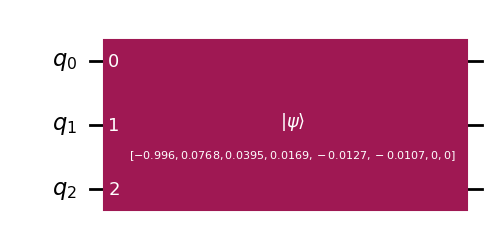

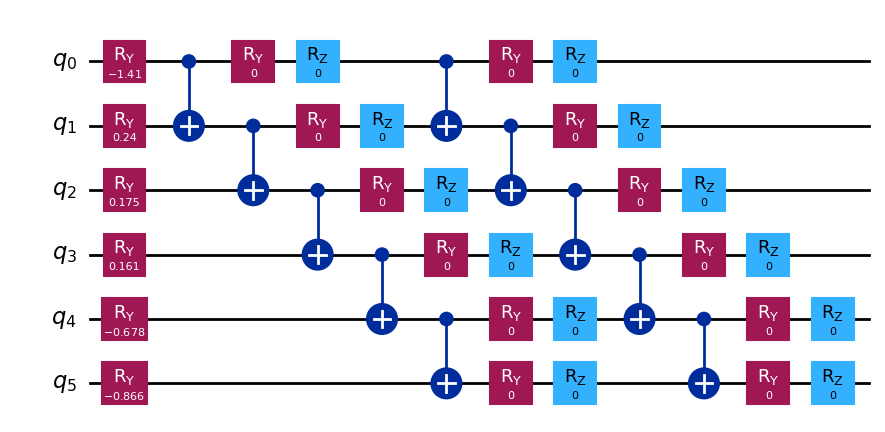

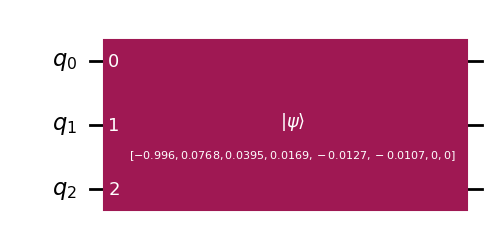

In [19]:
# Use a representative PCA input
x_sample = Xtr_in_pca[0]

# Angle: scale each PCA feature to [-pi/2, pi/2], then apply Ry per qubit
ang_scaler = MinMaxScaler(feature_range=(-math.pi/2, math.pi/2))
ang_scaler.fit(Xtr_in_pca)
angles = ang_scaler.transform(x_sample[None, :])[0]
qc_state_angle = build_angle_circuit(angles, thetas=np.zeros(ENTANGLING_DEPTH*len(angles)*2), depth=ENTANGLING_DEPTH)

# Amplitude: pad to 2^n and normalize to unit l2; initialize amplitudes
def next_pow2_geq(n):
    p=1
    while p<n: p<<=1
    return p
m = next_pow2_geq(len(x_sample))
amp = np.zeros(m, dtype=complex)
amp[:len(x_sample)] = x_sample
norm = np.linalg.norm(amp)
if norm>1e-12: amp/=norm
from qiskit import QuantumCircuit
qc_state_amp = QuantumCircuit(int(math.log2(m)))
qc_state_amp.initialize(amp)

# display(circuit_drawer(qc_state_angle, output='mpl'))
# display(circuit_drawer(qc_state_amp, output='mpl'))

circuit_drawer(qc_state_angle, output='mpl', fold=100)
circuit_drawer(qc_state_amp, output='mpl', fold=100)

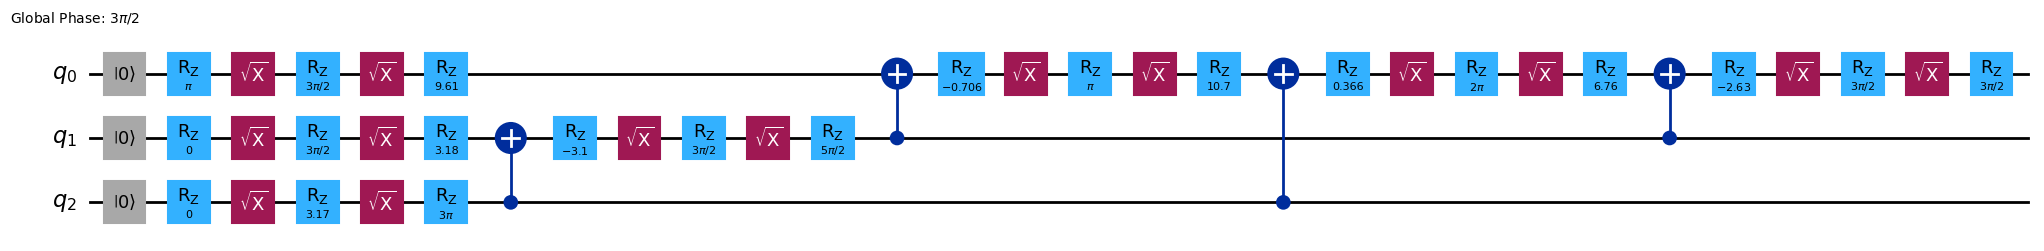

In [20]:
from qiskit import transpile

# 実機に近い基底ゲートセットへ展開（例：IBM系）
basis = ['rz', 'sx', 'x', 'cx']

# 最適化をかけずにまずは素直に分解（構造を見たいので optimization_level=0 推奨）
tc_amp = transpile(qc_state_amp, basis_gates=basis, optimization_level=0)

# 折り返し無しで描画（分割表示を避ける）
_ = circuit_drawer(tc_amp, output='mpl', fold=-1, idle_wires=False)

## Train PQC Models — Angle and Amplitude

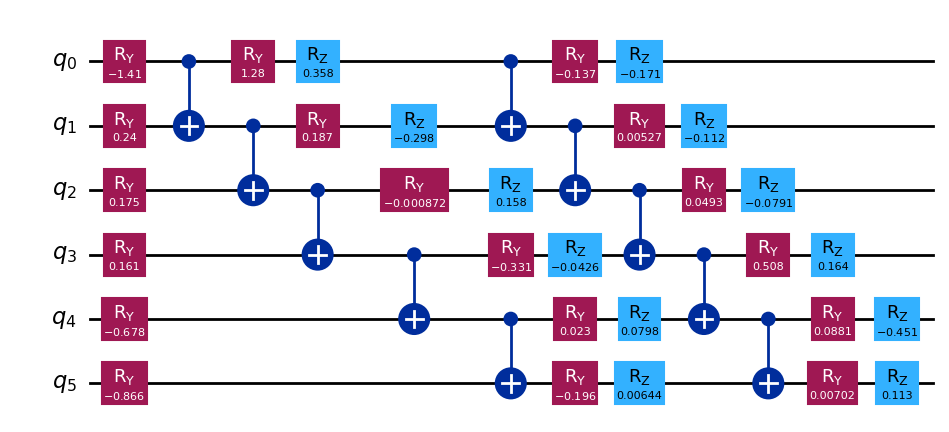

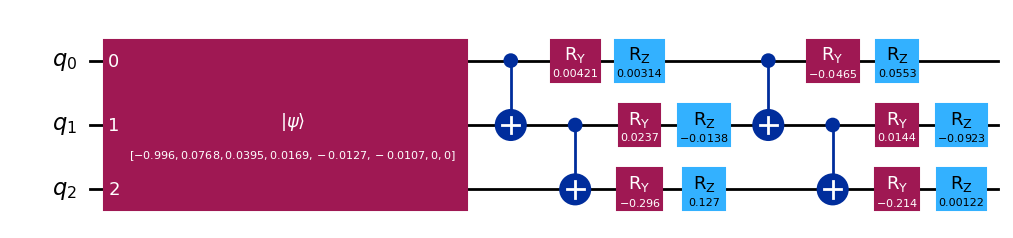

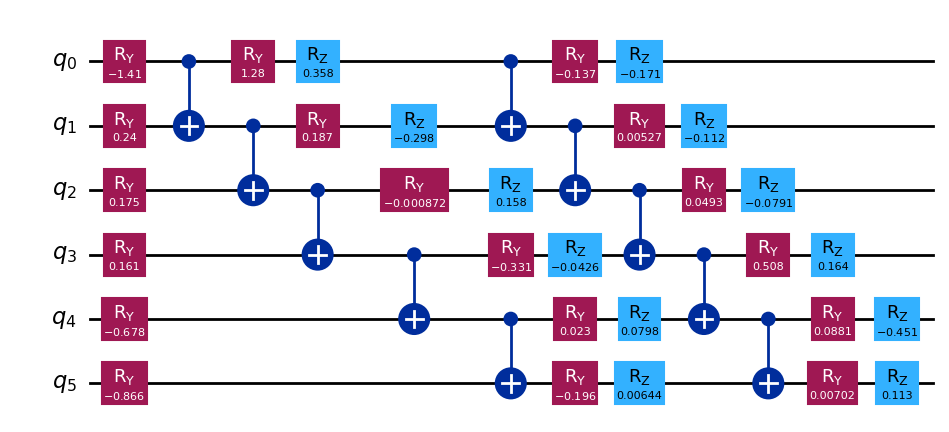

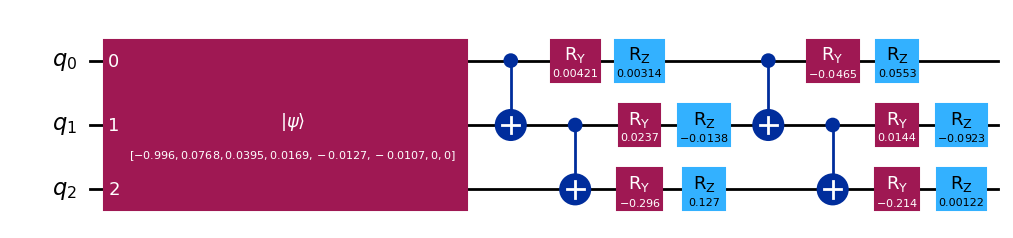

In [8]:
# Angle model
angle_model = PQCRegressor(n_qubits=Xtr_in_pca.shape[1], depth=ENTANGLING_DEPTH, random_state=0)
angle_model.fit(Xtr_in_pca, Xtr_out_pca, maxiter=250, verbose=False, restarts=2)
ytr_angle_pca = angle_model.predict(Xtr_in_pca)
yte_angle_pca = angle_model.predict(Xte_in_pca)
ytr_angle = inverse_pca(scaler, pca, ytr_angle_pca)
yte_angle = inverse_pca(scaler, pca, yte_angle_pca)

# Amplitude model
amp_model = PQCRegressorAmplitude(n_features=Xtr_in_pca.shape[1], depth=ENTANGLING_DEPTH, random_state=0)
amp_model.fit(Xtr_in_pca, Xtr_out_pca, maxiter=250, verbose=False, restarts=2)
ytr_amp_pca = amp_model.predict(Xtr_in_pca)
yte_amp_pca = amp_model.predict(Xte_in_pca)
ytr_amp = inverse_pca(scaler, pca, ytr_amp_pca)
yte_amp = inverse_pca(scaler, pca, yte_amp_pca)

# Show model circuits for the same PCA sample
qc_angle_full = angle_model.circuit_for_input(x_sample)
qc_amp_full = amp_model.circuit_for_input(x_sample)
display(circuit_drawer(qc_angle_full, output='mpl'))
display(circuit_drawer(qc_amp_full, output='mpl'))


## Metrics — MSE, RMSE, MAE, R2, Directional Fidelity

In [9]:
# Compute core metrics in original feature space
def metrics_block(y_true, y_pred, label=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{label} MSE={mse:.6f} RMSE={rmse:.6f} MAE={mae:.6f} R2={r2:.6f}')
    return mse, rmse, mae, r2

print('Original-space metrics (test):')
m_angle = metrics_block(inverse_pca(scaler, pca, yte_true), yte_angle, label='Angle')
m_amp   = metrics_block(inverse_pca(scaler, pca, yte_true), yte_amp,   label='Amplitude')

# Directional fidelity in PCA space: cosine similarity^2 between unit vectors
def mean_directional_fidelity(y_true_pca, y_pred_pca):
    eps=1e-12
    t = y_true_pca / (np.linalg.norm(y_true_pca, axis=1, keepdims=True)+eps)
    p = y_pred_pca / (np.linalg.norm(y_pred_pca, axis=1, keepdims=True)+eps)
    cs = np.sum(t*p, axis=1)
    return float(np.mean(cs*cs))

fid_angle = mean_directional_fidelity(yte_true, yte_angle_pca)
fid_amp   = mean_directional_fidelity(yte_true, yte_amp_pca)
print(f'Directional fidelity (PCA space): Angle={fid_angle:.6f}  Amplitude={fid_amp:.6f}')


Original-space metrics (test):
Angle MSE=0.001345 RMSE=0.036669 MAE=0.030057 R2=-12.441663
Amplitude MSE=0.000125 RMSE=0.011180 MAE=0.007704 R2=-0.191664
Directional fidelity (PCA space): Angle=0.587675  Amplitude=0.711712


## Plots — Parity, Heatmaps, RBF-style Overlay, and Future Rollout

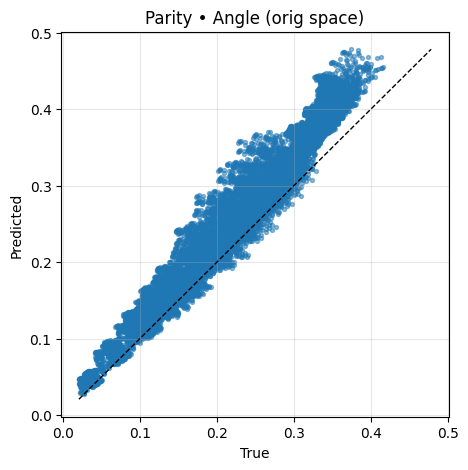

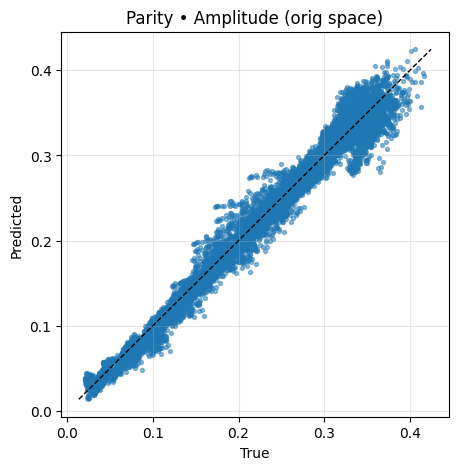

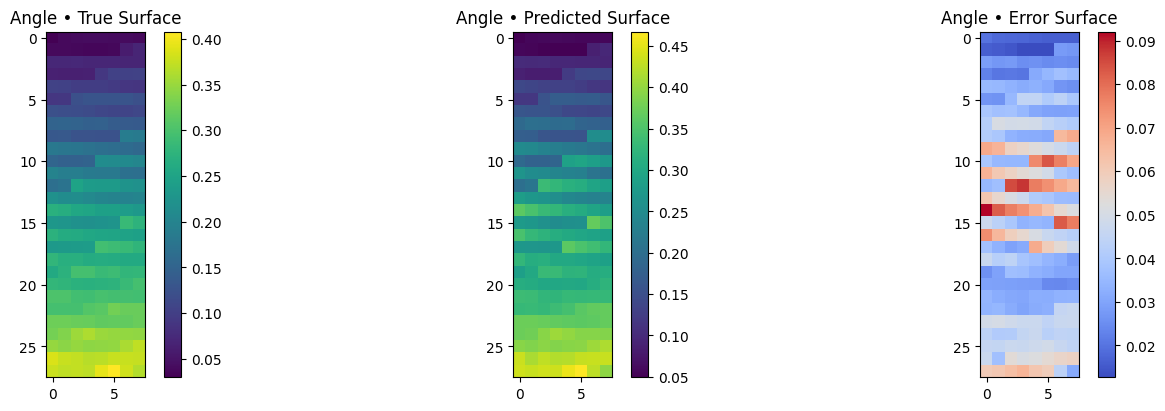

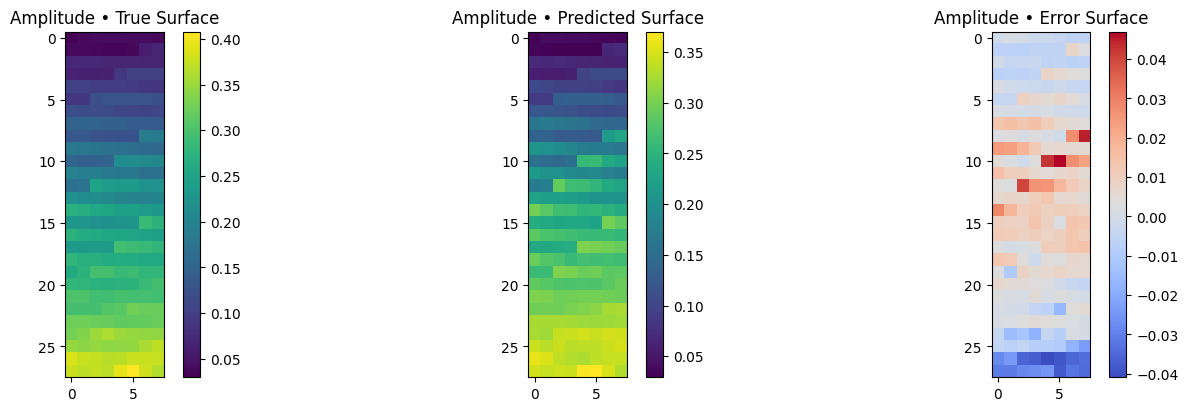

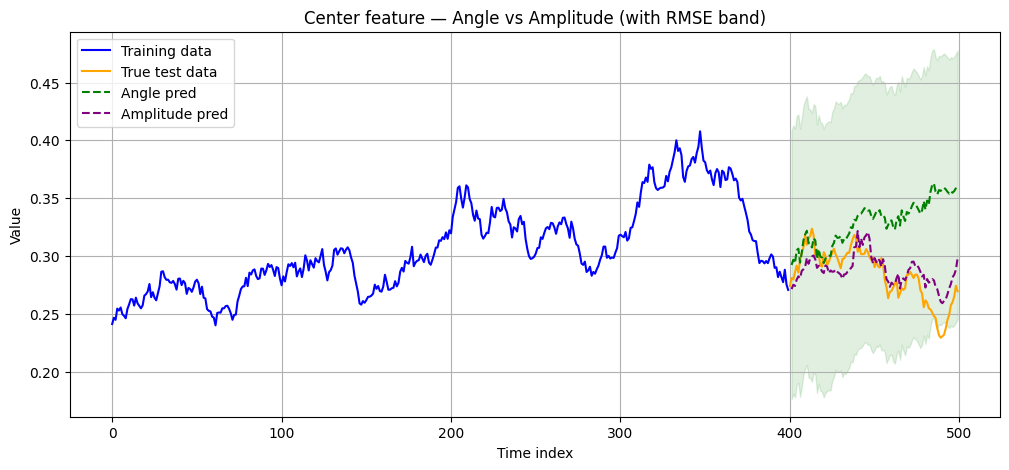

In [10]:
# Parity plots (test)
parity_plot(inverse_pca(scaler, pca, yte_true), yte_angle, title='Parity • Angle (orig space)')
parity_plot(inverse_pca(scaler, pca, yte_true), yte_amp,   title='Parity • Amplitude (orig space)')

# Heatmaps on last test sample
grid = guess_grid_shape(n_features, GRID_SHAPE)
last_true_vec = inverse_pca(scaler, pca, yte_true)[-1]
last_pred_angle = yte_angle[-1]
last_pred_amp   = yte_amp[-1]
plot_surface_heatmaps(last_true_vec, last_pred_angle, grid, title_prefix='Angle • ')
plot_surface_heatmaps(last_true_vec, last_pred_amp,   grid, title_prefix='Amplitude • ')

# RBF-style overlay at center feature
fi = n_features // 2
train_idx = np.arange(len(X_train_raw))
test_idx  = np.arange(len(X_train_raw), len(X_train_raw)+len(X_test_raw))
plt.figure(figsize=(12,5))
plt.plot(train_idx, X_train_raw[:, fi], label='Training data', color='blue')
plt.plot(test_idx,  X_test_raw[:, fi],  label='True test data', color='orange')
pred_angle = np.full_like(X_test_raw[:, fi], np.nan, dtype=float); pred_angle[1:] = yte_angle[:, fi]
pred_amp   = np.full_like(X_test_raw[:, fi], np.nan, dtype=float); pred_amp[1:]   = yte_amp[:, fi]
# RMSE band uses Angle RMSE (choose either)
rmse = math.sqrt(mean_squared_error(X_test_raw[1:, fi], pred_angle[1:]))
plt.plot(test_idx, pred_angle, '--', color='green',  label='Angle pred')
plt.plot(test_idx, pred_amp,   '--', color='purple', label='Amplitude pred')
plt.fill_between(test_idx, pred_angle - 1.96*rmse, pred_angle + 1.96*rmse, color='green', alpha=0.12)
plt.title('Center feature — Angle vs Amplitude (with RMSE band)')
plt.xlabel('Time index'); plt.ylabel('Value'); plt.grid(True); plt.legend(); plt.show()


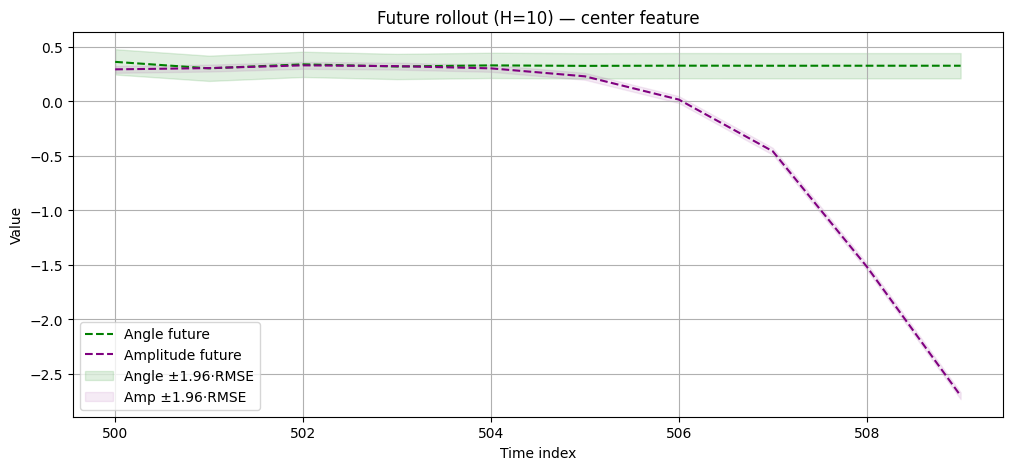

In [11]:
# Future rollout from the latest observed surface (H steps)
def rollout_future(model, scaler, pca, x0_orig, horizon):
    # x0_orig in original feature space
    xp0 = transform_with_pca(scaler, pca, x0_orig[None, :])[0]
    preds_orig = []
    cur = xp0.copy()
    for _ in range(horizon):
        if isinstance(model, PQCRegressorAmplitude):
            y1_pca = model.predict(cur[None, :])[0]
        else:
            y1_pca = model.predict(cur[None, :])[0]
        y1_orig = inverse_pca(scaler, pca, y1_pca[None, :])[0]
        preds_orig.append(y1_orig)
        cur = y1_pca
    return np.asarray(preds_orig)

H = 10
future_angle = rollout_future(angle_model, scaler, pca, X_raw[-1], H)
future_amp   = rollout_future(amp_model,   scaler, pca, X_raw[-1], H)
fi = n_features // 2
idx_future = np.arange(len(X_train_raw) + len(X_test_raw), len(X_train_raw) + len(X_test_raw) + H)

# Compute RMSE on test predictions (avoiding NaN)
pred_angle_feat = np.full_like(X_test_raw[:, fi], np.nan, dtype=float)
pred_angle_feat[1:] = yte_angle[:, fi]
valid_a = np.isfinite(X_test_raw[1:, fi]) & np.isfinite(pred_angle_feat[1:])
rmse_a = math.sqrt(mean_squared_error(X_test_raw[1:, fi][valid_a], pred_angle_feat[1:][valid_a])) if np.any(valid_a) else np.nan

pred_amp_feat = np.full_like(X_test_raw[:, fi], np.nan, dtype=float)
pred_amp_feat[1:] = yte_amp[:, fi]
valid_b = np.isfinite(X_test_raw[1:, fi]) & np.isfinite(pred_amp_feat[1:])
rmse_b = math.sqrt(mean_squared_error(X_test_raw[1:, fi][valid_b], pred_amp_feat[1:][valid_b])) if np.any(valid_b) else np.nan

plt.figure(figsize=(12,5))
plt.plot(idx_future, future_angle[:, fi], '--', color='green',  label='Angle future')
plt.plot(idx_future, future_amp[:,   fi], '--', color='purple', label='Amplitude future')

# Add RMSE bands if valid
if not np.isnan(rmse_a):
    plt.fill_between(idx_future, future_angle[:, fi] - 1.96*rmse_a, future_angle[:, fi] + 1.96*rmse_a,
                     color='green', alpha=0.12, label='Angle ±1.96·RMSE')
if not np.isnan(rmse_b):
    plt.fill_between(idx_future, future_amp[:, fi] - 1.96*rmse_b, future_amp[:, fi] + 1.96*rmse_b,
                     color='purple', alpha=0.08, label='Amp ±1.96·RMSE')

plt.title(f'Future rollout (H={H}) — center feature')
plt.xlabel('Time index'); plt.ylabel('Value'); plt.grid(True); plt.legend(); plt.show()

ExactExplainer explainer: 100it [32:07, 19.47s/it]                       
ExactExplainer explainer: 100it [18:50, 11.53s/it]                       

=== Angle model SHAP summary ===


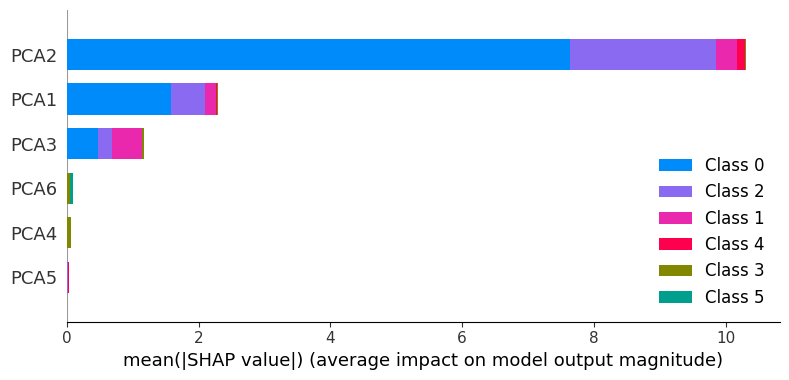

=== Amplitude model SHAP summary ===


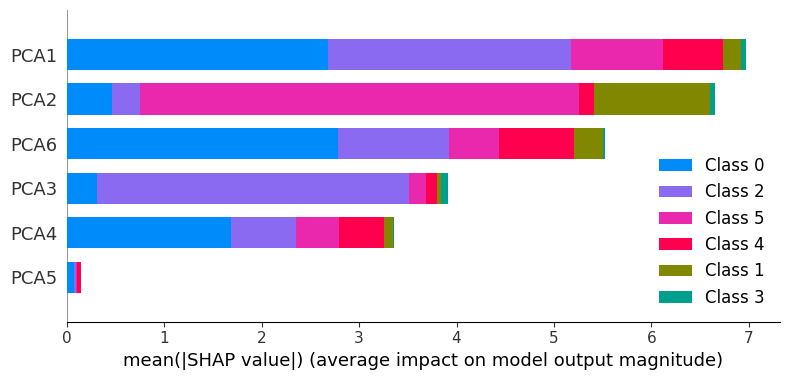

Explaining sample #0


ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (6, 6)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [12]:
# === SHAP-based feature importance for PQC models ===
import shap

# Wrapper for SHAP: the model must accept X (numpy) and return y_pred
def predict_angle(X):
    return angle_model.predict(X)

def predict_amp(X):
    return amp_model.predict(X)

# We analyze in PCA space to avoid large dimension explosion
X_sample = Xte_in_pca  # test inputs
explainer_angle = shap.Explainer(predict_angle, X_sample)
explainer_amp   = shap.Explainer(predict_amp,   X_sample)

# Compute SHAP values (can be heavy if data large)
shap_values_angle = explainer_angle(X_sample[:100])  # limit for speed
shap_values_amp   = explainer_amp(X_sample[:100])

# Plot SHAP summary (importance ranking)
print("=== Angle model SHAP summary ===")
shap.summary_plot(shap_values_angle, X_sample[:100], feature_names=[f"PCA{i+1}" for i in range(X_sample.shape[1])])

print("=== Amplitude model SHAP summary ===")
shap.summary_plot(shap_values_amp, X_sample[:100], feature_names=[f"PCA{i+1}" for i in range(X_sample.shape[1])])

# Optional: visualize one sample explanation
idx = 0
print(f"Explaining sample #{idx}")
shap.plots.waterfall(shap_values_angle[idx], max_display=10)